**Table of contents**<a id='toc0_'></a>    
- [Setting up the compute_orbits file](#toc1_1_)    
    - [Compilation of compute_orbits.cpp](#toc1_1_1_)    
    - [Testing the executable file](#toc1_1_2_)    
    - [Inspecting in python](#toc1_1_3_)    
      - [Results for a variety of dt values](#toc1_1_3_1_)    
  - [Creating the Animation](#toc1_2_)    
    - [Inspecting z-axis Components](#toc1_2_1_)    
    - [Creating an Animation of the Orbits](#toc1_2_2_)    
      - [Observational Checks](#toc1_2_2_1_)    
    - [Checking the Animation Against the jupiter.db File](#toc1_2_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [21]:
database_service = "sqlite"
database = "jupiter.db"
connectable =  f"{database_service}:///{database}" ## Creating a variable to connect to the database

db_contents = pd.read_sql("SELECT * FROM sqlite_master", connectable) ## Creating a variable to contain the details of the database

moons = pd.read_sql("SELECT * FROM moons", connectable) ## Creating a variable to contain the details of the moons table

## <a id='toc1_1_'></a>[Setting up the compute_orbits file](#toc0_)

### <a id='toc1_1_1_'></a>[Compilation of compute_orbits.cpp](#toc0_)

The first step is to simply compile to cpp file, which requires all the necessary files to be compiled simultaneously. 

To do this, I used the command:  
`g++ -std=c++17 body.cpp vector3D.cpp compute_orbits.cpp -o compute_orbits`  

This command compiles the body, vector3D and compute_orbits files into one executable program of compute_orbits.

### <a id='toc1_1_2_'></a>[Testing the executable file](#toc0_)

Now the file compute_orbits has been created, I will use the information from the Assessment1.ipynb file which shows how to run the exec file with the correct inputs.

To test the file, I will use the command:  
`./compute_orbits jupiters_moons.csv moon_orbits.csv 1e-1 1 1`  
as provided in the assessment instructions. 

This created a csv file with the laid out as describe by the Assessment1 file, showing that the executable file was created successfully.


### <a id='toc1_1_3_'></a>[Inspecting in python](#toc0_)

Now I will check that `<E>` and `<Lmag>` fields are conserved through the file and find the best value of `<dt>` to use to have the best conservation of `<E>`

In [22]:
with open("moon_orbits_test.csv") as f:
    line1 = f.readline().strip()
    line2 = f.readline().strip()

dt, T, T_save, N = map(float, line1.split(','))

orbits = pd.read_csv("moon_orbits_test.csv", skiprows = 2)

energy, Lmag = orbits["energy"], orbits["ang_mom"]
print(energy, "\n")
print(Lmag)


0   -4.037867e+04
1    6.876514e+07
Name: energy, dtype: float64 

0    211.230391
1    211.230391
Name: ang_mom, dtype: float64


From this output, it is clear that the energy values are very different over the space of 0.1 second, whereas the angular momentum value is the same up to 9 significant figures.  
To find the best `<dt>` value to use where the energy is conserved to a good approximation - difference is 0 to 3 dp -, I will test different values in the exec file, starting at a very small value that should have no change and increasing it until significant change occurs.

In [23]:
with open("moon_orbits.csv") as f:
    line1 = f.readline().strip()
    line2 = f.readline().strip()

dt, T, T_save, N = map(float, line1.split(','))

orbits = pd.read_csv("moon_orbits.csv", skiprows = 2)

energy, Lmag = orbits["energy"], orbits["ang_mom"]

energy_diff = energy[1] - energy[0]
print(energy_diff)

8.92152456799522e-06


#### <a id='toc1_1_3_1_'></a>[Results for a variety of dt values](#toc0_)

| `dt` value | difference in `energy` | Number of steps |
|:-----------|:----------------------:|----------------:|
|0.1         |68800000                |0                |
|0.0000001   |-1.45519e-11            |510367           |
|0.001       |3680                    |51               |
|0.0001      |0.00325                 |510              |
|0.00001     |-3.47726e-6             |5103             |
|0.000001    |-3.85625e-9             |51036            |
|0.000005    |-4.61041e-7             |10207            |

From this table of differences, I will take the best value of `<dt>` to be 0.00005
(Number of steps is found in the next section)
Now I will find the number of time steps required to complete the longest orbit and plot a graph of Energy against time to show that the approximation is accurate enough.

I will plot the energy change from the original energy value recorded to clearly show how the change is minimal.


The number of steps to ensure that every moon has completed a full orbit is 10207


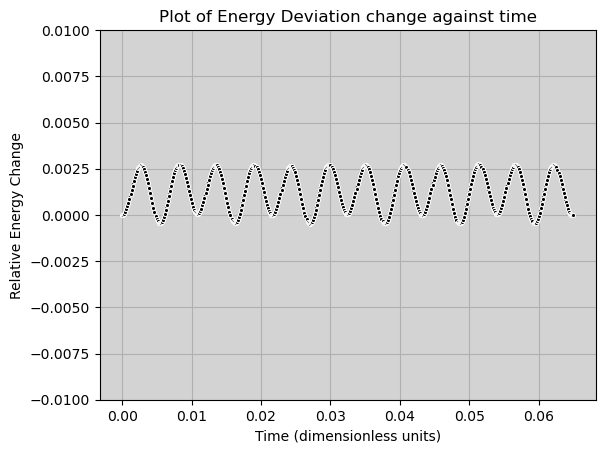

The maximum deviation from the original energy value in this time is 0.00273762


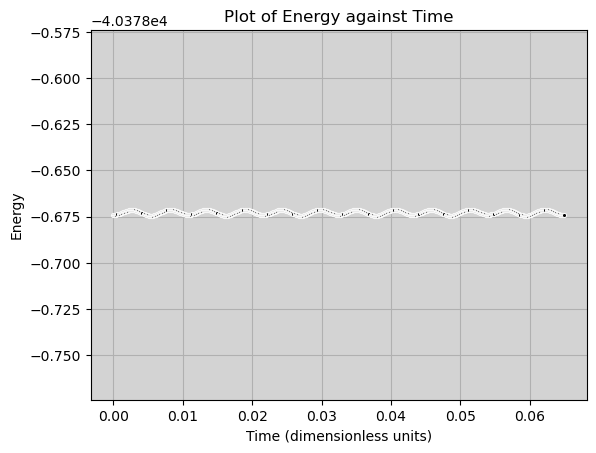

In [24]:
moon_names = ["Callisto", "Io", "Europa", "Ganymede"]

new_moons = moons[moons["moon"].isin(moon_names)]
largest_period = new_moons["period_days"].max() ## Units of Days

E_0 = orbits["energy"].iloc[0]
orbits["energy_diff"] = (orbits["energy"] - E_0) 

t_s = 327 ## Time in days
time_simulation = largest_period/t_s

num_steps = int(time_simulation / dt)

print(f'The number of steps to ensure that every moon has completed a full orbit is {num_steps}')


fig, ax = plt.subplots()
ax.set_facecolor('lightgrey') ## makes it easier to see the points on the graph
sns.lineplot(data = orbits, x = "time", y = "energy_diff", marker = ".", color = 'black')
plt.xlabel("Time (dimensionless units)")
plt.ylabel("Relative Energy Change")
plt.title("Plot of Energy Deviation change against time")
plt.grid(True)
plt.ylim( -0.01, 0.01)
plt.show()


## FInding maximum deviation

energies = orbits["energy"].to_numpy()
absolute_dev = abs(energies - E_0)
maximum_absolute = max(absolute_dev)

print(f'The maximum deviation from the original energy value in this time is {maximum_absolute:.6g}')

fig, ax = plt.subplots()
ax.set_facecolor('lightgrey') ## makes it easier to see the points on the graph
sns.lineplot(data = orbits, x = "time", y = "energy", marker = ".", color = 'black')
plt.xlabel("Time (dimensionless units)")
plt.ylabel("Energy")
plt.title("Plot of Energy against Time")
plt.grid(True)
plt.ylim(E_0 - 0.1, E_0 + 0.1)
plt.show()




Considering that the initial energy value is about -40379, this max deviation is incredibly insignificant as it is a deviation of ~(6.8e-6)%, which is incredibly small.  

Due to this, I will take `<dt>` as 5e-6 because it produces very insignificant deviation as well as requiring 10207 time steps to complete the longest orbital period, which is not too large a number of steps for running a compiles c++ program.

Note that the command used to create the file for these graphs is  
`./compute_orbits jupiters_moons.csv moon_orbits.csv 5e-6 13000 30`  
I used save every 30 values to reduce the storage required for the animation.  
I also perform 13000 steps as it allows me to find the period of Callisto more easily later from the data, while still being able to stop the animation at 10207 steps. It alos doesn't greatly increase the size of moon_orbits.csv.


## <a id='toc1_2_'></a>[Creating the Animation](#toc0_)

### <a id='toc1_2_1_'></a>[Inspecting z-axis Components](#toc0_)

To see if the moons are moving through the z plane in the orbit, I will find the maximum and minimum r{i}z value for each moon and find the maximum distance in the z-axis the moons travel.

This will hopefully show that there is no significant z-axis motion and therefore the moons can be assumed to be moving only in the x-y plane.

In [25]:
## I will use the moon_names list from earlier
names = ["Jupiter"] + moon_names

def r_change(a, i):
    r_field = f'r{i+1}{a}'
    r_min = orbits[r_field].min()
    r_max = orbits[r_field].max()
    change = r_max - r_min
    return change


for i, moon in enumerate(names[1:]):
    x_change = r_change('x', i)
    y_change = r_change('y', i)
    z_change = r_change('z', i)
    print(f'For {moon}: \n'
          f'The r_x value changes by {x_change:.2g},\n' 
          f'The r_y value changes by {y_change:.2g},\n'
          f'The r_z value changes by {z_change:.2g}.\n')


For Callisto: 
The r_x value changes by 0.0012,
The r_y value changes by 0.00073,
The r_z value changes by 8e-06.

For Io: 
The r_x value changes by 1.9,
The r_y value changes by 1.9,
The r_z value changes by 0.064.

For Europa: 
The r_x value changes by 0.42,
The r_y value changes by 0.42,
The r_z value changes by 0.016.

For Ganymede: 
The r_x value changes by 0.67,
The r_y value changes by 0.67,
The r_z value changes by 0.027.



From the above code, it is clear that the z values, when compared to the x and y, do not change in any way that is significant enough to require them to be plot in the animation, therefore it can be assumed that the moons orbit only in the x-y plane for the next task.

### <a id='toc1_2_2_'></a>[Creating an Animation of the Orbits](#toc0_)

Next I will create the animation to depict how the moons orbit around Jupiter using the data calculated with the compute_orbits.cpp file.

Initially, I import 2 new classes and 1 library into the file. The main one of these is FuncAnimation, which I use to te the animation, PillowWriter is simply used to export the animation as a gif at the end of the program, so that it can be displayed in the following markdown cell, and math is used only to round up the value used to state how many frames should be used.

First, I create an empty dictionary called 'positions' and then fill it with arrays of the x and y values taken from the 'orbits' data frame created prior. *The format of the dictionary can be seen in comments on line 12.*

Next, I set up the figure that is used for the plot, by adjusting the x and y axis scale, before removing the visable axis and frame around the plot, allowing a less cluttered animation at the end.

To reduce the size of the animation, I opted to manually plot the orbital circles then animate the position of the moon at each frame, as opposed to animating a trail behind the moon to draw ou the orbit, as this works wel for small data sets, however for this it greatl impacted performance and the size of the file as it had to render every single point each frame.

I used the list 'lines' to create the animation, as the list was updated to store the x and y positions of each moon with every update frame.  
The init function reset the values in lines back to `([],[])` whenever FuncAnimation is called.

In [26]:
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter
import math

positions = {} ## Dictionary to store x and y values for each moon

for i, name in enumerate(names):
    x = f'r{i+1}x'
    y = f'r{i+1}y'
    x_values = orbits[x].to_numpy()
    y_values = orbits[y].to_numpy()
    positions[name] = {'x': x_values, 'y': y_values} ## Format of {name: {rix: [x1, x2, ...], riy: [y1, y2, ...]}}

fig, ax = plt.subplots(figsize = (6,6))

ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_aspect('equal', adjustable = 'box')

## Remove x and y values from the axis
ax.set_xticks([])
ax.set_yticks([])

## Remove the plot outline
for spine in ax.spines.values():
    spine.set_visible(False)

## Plot the circles of the orbits
for name in names:
    ax.plot(positions[name]['x'], positions[name]['y'], alpha=0.3)

## Create a list to store the values to be plot
lines = []
for name in names:
    line, = ax.plot([],[], 'o', label = name)
    lines.append(line)

## Reset the data in lines for each update
def init():
    for l in lines:
        l.set_data([],[])
    return lines

## Plot the position of each moon at each frame
def update_data(frame):
        for i, name in enumerate(names):
            x = positions[name]['x'][frame]
            y = positions[name]['y'][frame]
            lines[i].set_data([x], [y])
        return lines

frames = math.ceil(10207/T_save) ## Number of frames required to complete the longest orbit
animation = FuncAnimation(
                fig = fig,
                func = update_data,
                frames = frames, 
                init_func = init,
                interval = 25,
                repeat = True,
                blit = True
)

legend = ax.legend(loc = 'upper center', ncol = 5, bbox_to_anchor = (0.5, 1.1))
legend.get_frame().set_alpha(0) 
legend.get_frame().set_edgecolor('none')

plt.close()

writer = PillowWriter(fps = 30)
animation.save("orbit_animation.gif", writer = writer)




![Orbit Animation](orbit_animation.gif)


#### <a id='toc1_2_2_1_'></a>[Observational Checks](#toc0_)

To quickly check that the animation wasn't incredibly incorrect, I made sure that:  
- the inner moons were orbiting at a faster rate that any moon further out from it  
- Jupiter was not obviously moving in any significant way
- the moons stuck to the paths of the orbits drawn out separately
- the spacing and size of the orbits is as expected
- the orbits are not cleary elliptical, but resemble circles

### <a id='toc1_2_3_'></a>[Checking the Animation Against the jupiter.db File](#toc0_)

Now I will find the value of the period given by this animation and check if it aligns with the previous periods given in jupiter.db.  

In [27]:
import numpy as np

time = orbits['time'].to_numpy()

def find_period(time, x, y):
    crossings = []
    for i in range(len(y) - 1):
        if x[i] < 0 and x[i+1] >= 0 and y[i] < 0:  ## Records whenever the moon crosses the y axis at a negative y value.
            crossings.append(time[i])
            
    if len(crossings) < 2:
        return None
    
    period = crossings[1] - crossings[0] 
    
    ## As t = time/t_s, real time = t * t_s
    return (period * 2.827e+7) / 86400 ## time in days

for name in names[1:]:
    x = positions[name]['x']
    y = positions[name]['y']
    P_sim = find_period(time, x, y)
    known_period = moons.loc[moons["moon"] == name, "period_days"].iloc[0]
    print(f'The period of {name} from the animation is {P_sim:.3f} and the period from jupiter.db is {known_period:.3f}.\n')



The period of Callisto from the animation is 16.687 and the period from jupiter.db is 16.689.

The period of Io from the animation is 1.767 and the period from jupiter.db is 1.750.

The period of Europa from the animation is 3.583 and the period from jupiter.db is 3.551.

The period of Ganymede from the animation is 7.166 and the period from jupiter.db is 7.150.



From this code, there is clearly a slight disparity between the original period values and the ones used in the animation.  
However, the difference is quite small, with it affecting all of the moons at a hundredth of a day.

I belive that this disparity could be caused by the fact that the energy in the system is not perfectly conserved, even though the change is incredibly small, as shown earlier in the section.  
If the energy value is slightly incorrect at any point in the calulation, a slight error in some of the values could be created and this error may snowball into being noticable at larger time increments.

Another factor that may have introduced very slight error into the period value, is the fact that I used T_save as 30 to reduce the load of the program, so if the point I measure the period at occured during a step between these saves, it may be very slightly off.  
However, I am not sure that this could've had as big of an effect as shown by the data above due to the time steps being very small, but it could have been a factor had I used a larger time step to reduce load instead of increasing T_save.
